In [42]:
from random import seed
from random import random
from random import uniform
import math
import pandas as pd
import numpy as np
from numpy import linalg

In [43]:
def initialize_network(D, nh, c):
    Wh = np.zeros((D+1,nh+1)) # +1 do bias
    for j in range(D+1): # +1 do bias
        for i in range(nh+1): # +1 do bias
            weight = uniform(-1/math.sqrt(D),1/math.sqrt(D))
            Wh[j][i] = weight
            
    Ws = np.zeros((nh+1,c)) # +1 do bias
    for j in range(nh+1): # +1 do bias
        for i in range(c):
            weight = uniform(-1/math.sqrt(D),1/math.sqrt(D))
            Ws[j][i] = weight
    return Wh,Ws

In [44]:
# Transfer neuron activation
def phi(activation):
	a = 1.716 # constante de nao linearidade
	b = 2/3 # constante de nao linearidade
	return a*math.tanh(b*activation)

In [45]:
# Calculate the derivative of an neuron output
def phi_derivative(output):
	a = 1.716 # constante de nao linearidade
	b = 2/3 # constante de nao linearidade
	return a*b*(1 - (math.tanh(b*output))**2)

In [46]:
def forward_propagate(xk,Wh,Ws):
    # FORWARD PROPAGATION
    vj = np.dot(xk,Wh) # soma das entradas multiplicadas pelos pesos da camada escondida para cada neuronio (resulta em um vetor 1x2)
    Y = np.zeros(len(vj)) # aplica a funcao phi para os dois neuronios
    for i in range(len(vj)):
        Y[i] = phi(vj[i])
    vk = np.dot(Y,Ws)
    Z = np.zeros(len(vk))
    for j in range(len(vk)):
        Z[j] = phi(vk[j])
    # print(vk)

    return Y,Z

In [47]:
def calculate_deltas(e,Z,Y,Ws,D,nh,eta,xk,Wh,c):
    # BACKPROPAGATION
    phi_linhak = np.zeros(len(Z))
    for k in range(len(Z)):
        phi_linhak[k] = phi_derivative(Z[k])

    # eq. 4.46 do livro
    deltak = np.multiply(e,phi_linhak)

    phi_linhaj = np.zeros(len(Y))
    for l in range(len(Y)):
        phi_linhaj[l] = phi_derivative(Y[l])

    # eq. 4.46 do livro
    deltaj = np.multiply(phi_linhaj,np.dot(deltak,Ws.T)) # delta para os neuronios da camada escondida
    
    deltawh = np.zeros((D+1,nh+1))
    deltaws = np.zeros((nh+1,c))

    # eq. 4.47 do livro - atualizacao de pesos da camada escondida
    for i in range(D+1): # +1 do bias
        for j in range(nh+1): # +1 do bias
            deltawh[i][j] = eta*deltaj[j]*xk[i]
            
    # eq. 4.47 do livro - atualizacao de pesos da camada de saida
    for i in range(nh+1): # +1 do bias
        for j in range(c):
            deltaws[i][j] = eta*deltak[j]*Y[i]
    return deltawh,deltaws

In [48]:
def backward_propagate(D,nh,c,Wh,Ws,deltawh,deltaws):
    # BACKPROPAGATION
    # eq. 4.47 do livro - atualizacao de pesos da camada escondida
    for i in range(D+1): # +1 do bias
        for j in range(nh+1): # +1 do bias
            Wh[i][j] = Wh[i][j] + deltawh[i][j]

    # eq. 4.47 do livro - atualizacao de pesos da camada de saida
    for i in range(nh+1): # +1 do bias
        for j in range(c):
            Ws[i][j] = Ws[i][j] + deltaws[i][j]
            
    return Wh,Ws

In [52]:
x = pd.read_csv('Anexo 1 da Lista 4 - treina.txt',sep='        ',header=None, engine='python')
N = len(x)
x.columns = ['x1','x2','x3','x4','classe']
expected = x['classe']
x = x.drop(columns=['classe'])
# normalizacao dos dados de entrada
x = (x - x.mean())/x.std()

x.insert(0,'b',1) # adicionando +1 como entrada do bias

d = list()

# converte o rotulo da saida para um vetor numerico com -1 ou +1
for row in expected:
    cod = [-1,-1,-1]
    cod[int(row)-1] = 1
    d.append(cod)
d = np.array(d)
x = x.to_numpy()

In [53]:
D = 4 # dimensão do espaço de entrada
nh = 2 # numero de neuronios na camada escondida
c = 3 # numero de classes
eta = 0.1 # taxa de aprendizagem
nmax = 200 # numero maximo de epocas
Wh,Ws = initialize_network(D, nh, c)
# print(Ws)
# print(x)

In [54]:
# TREINAMENTO BATCH
n = 1
avg_err_ant = 0
theta = 0
evolucao_crit_parada = np.empty((0,2), float)
# print(evolucao_crit_parada)
while n < nmax:
    if theta > 0.1 or n == 1:
        err_vec = list()
        deltawh = np.zeros((D+1,nh+1))
        deltaws = np.zeros((nh+1,c))
        for idx, xk in enumerate(x):
            Y,Z = forward_propagate(xk,Wh,Ws)
            # eq. 4.45 do livro
            e = d[idx] - Z
            err_vec.append([i*i for i in e])
            deltawh_i,deltaws_i = calculate_deltas(e,Z,Y,Ws,D,nh,eta,xk,Wh,c)
            deltawh = np.add(deltawh,deltawh_i)
            deltaws = np.add(deltaws,deltaws_i)

        deltawh = deltawh/N
        deltaws = deltaws/N
        Wh,Ws = backward_propagate(D,nh,c,Wh,Ws,deltawh,deltaws)
        err_vec = np.array(err_vec)
        avg_err = np.mean(err_vec, axis=0)
        # delta_avg_err = avg_err_ant - avg_err
        # theta = linalg.norm(delta_avg_err)
        theta = linalg.norm(avg_err)
        evolucao_crit_parada = np.append(evolucao_crit_parada,np.array([[n,theta]]),axis=0)

        avg_err_ant = avg_err
        print(f'epoca: {n}, theta: {theta}\n')
    else: 
        n = nmax
    
    n += 1

epoca: 1, theta: 1.2935495136066308

epoca: 2, theta: 1.2324727256282495

epoca: 3, theta: 1.1993143235769055

epoca: 4, theta: 1.1724665972083976

epoca: 5, theta: 1.1470427305897388

epoca: 6, theta: 1.122463482034712

epoca: 7, theta: 1.099043361871567

epoca: 8, theta: 1.0770981397270365

epoca: 9, theta: 1.0567626296478096

epoca: 10, theta: 1.038005914095104

epoca: 11, theta: 1.0206921709082366

epoca: 12, theta: 1.0046397708881682

epoca: 13, theta: 0.9896644023024971

epoca: 14, theta: 0.9756042573754068

epoca: 15, theta: 0.9623303387979986

epoca: 16, theta: 0.9497465582072185

epoca: 17, theta: 0.9377841098154156

epoca: 18, theta: 0.926393619226035

epoca: 19, theta: 0.9155374155888681

epoca: 20, theta: 0.9051832591715645

epoca: 21, theta: 0.8953000732851822

epoca: 22, theta: 0.8858556813943145

epoca: 23, theta: 0.8768162108421387

epoca: 24, theta: 0.8681466618320854

epoca: 25, theta: 0.8598121171939664

epoca: 26, theta: 0.8517791417942249

epoca: 27, theta: 0.84401

In [55]:
# print(Wh)
# print(Ws)
pred = list()
# print(x)
for xk in x:
    Y,Z = forward_propagate(xk,Wh,Ws)

    index = np.where(Z == max(Z))[0][0]

    Ck = index + 1
    
    pred.append(Ck)
    
pred = pd.Series(pred, copy=False)
results = {'desired': expected,'predicted':pred}
results = pd.DataFrame(data=results)
    
print(results)

    desired  predicted
0         3          3
1         1          1
2         3          3
3         3          3
4         1          1
..      ...        ...
70        2          2
71        3          3
72        2          2
73        2          2
74        3          3

[75 rows x 2 columns]


In [56]:
confusion_matrix = pd.crosstab(results['desired'], results['predicted'], rownames=['desired'], colnames=['predicted'])
print(confusion_matrix)

predicted   1   2   3
desired              
1          25   0   0
2           0  23   2
3           0   1  24


In [57]:
pred = list()
x = pd.read_csv('Anexo 2 da Lista 4 - teste.txt',sep='	',header=None, engine='python')
x_not_norm = x
x_not_norm = x_not_norm.to_numpy()
x = (x - x.mean())/x.std()
x.insert(0,'b',1) # adicionando +1 como entrada do bias
x = x.to_numpy()

for xk in x:
    Y,Z = forward_propagate(xk,Wh,Ws)

    index = np.where(Z == max(Z))[0][0]

    Ck = index + 1
    
    pred.append(Ck)
    
pred = pd.Series(pred, copy=False)

contagem1 = pred[pred == 1].count()
contagem2 = pred[pred == 2].count()
contagem3 = pred[pred == 3].count()
    
print(f'contagem de classificação 1: {contagem1}\n')
print(f'contagem de classificação 2: {contagem2}\n')
print(f'contagem de classificação 3: {contagem3}\n')

contagem de classificação 1: 12

contagem de classificação 2: 14

contagem de classificação 3: 13



In [58]:
print(Wh)

[[-0.37886212 -0.95709813 -1.04223535]
 [-0.20646358  0.10477525 -0.00345252]
 [ 0.89218919 -0.10851577 -0.29214851]
 [-0.9138519   0.00740061  0.93926867]
 [-0.27813233 -0.06674572  0.79159605]]


In [59]:
print(Ws)

[[ 0.63549598 -0.89617819  0.39081045]
 [ 0.23225405  1.11027146 -0.32718414]
 [-0.12338434 -1.00964022  1.20620702]]


In [60]:
x_df = pd.DataFrame(x_not_norm, columns=['x1','x2','x3','x4'])
x_df['classe'] = pred
print(x_df)

x_df.to_csv('ex4_batch_pred_results.csv',index=False)

     x1   x2   x3   x4  classe
0   5.7  2.8  4.1  1.3       2
1   7.6  3.0  6.6  2.1       3
2   4.9  2.5  4.5  1.7       3
3   7.3  2.9  6.3  1.8       3
4   4.8  3.0  1.4  0.1       1
5   4.5  2.3  1.3  0.3       2
6   6.3  2.3  4.4  1.3       2
7   6.1  3.0  4.6  1.4       2
8   4.6  3.4  1.4  0.3       1
9   5.5  2.5  4.0  1.3       2
10  5.5  2.6  4.4  1.2       2
11  5.0  3.4  1.5  0.2       1
12  4.4  2.9  1.4  0.2       1
13  5.0  3.6  1.4  0.2       1
14  5.4  3.9  1.7  0.4       1
15  5.8  2.6  4.0  1.2       2
16  5.0  2.3  3.3  1.0       2
17  5.6  2.7  4.2  1.3       2
18  6.4  3.1  5.5  1.8       3
19  7.2  3.6  6.1  2.5       3
20  4.9  3.1  1.5  0.1       1
21  5.4  3.7  1.5  0.2       1
22  4.8  3.4  1.6  0.2       1
23  7.7  3.0  6.1  2.3       3
24  6.3  3.4  5.6  2.4       3
25  4.4  3.0  1.3  0.2       1
26  5.1  3.4  1.5  0.2       1
27  5.0  3.5  1.3  0.3       1
28  6.7  3.1  5.6  2.4       3
29  6.9  3.1  5.1  2.3       3
30  6.2  2.9  4.3  1.3       2
31  5.1 

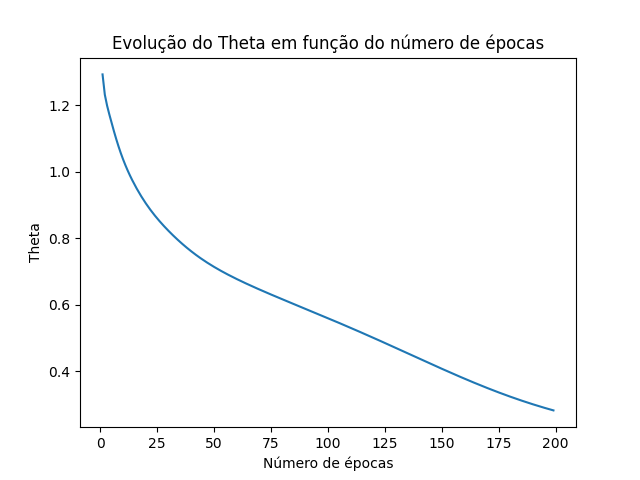

In [61]:
import matplotlib.pyplot as plt
plt.plot(evolucao_crit_parada[:,0],evolucao_crit_parada[:,1]) 
plt.title("Evolução do Theta em função do número de épocas") 
plt.xlabel("Número de épocas") 
plt.ylabel("Theta") 
plt.show()